In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_tasks_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler
from train import config_load_special
import numpy as np
from utils.manual_solvers import w_sig_NGgenerator, w_sig_NGposterior, w_sig_ridge
import copy



%matplotlib inline
%load_ext autoreload
%autoreload 2


all_experiments = ["leave045", "leave045_addEmbed", "leave045_addSegEmbed", "leave045_addFloatingEmbed"]

corresponding_paths = {
}

## load everything

model_dic = {}
config_dic = {}
ys_dic = {}
mus_dic = {}
sigs_dic = {}
exempt_dic = {}
predmu_dic = {}
predsigma_dic = {}

bayes_mus_dic = {}
bayes_sigs_dic = {}
ridge_mus_dic = {}
ridge_sigs_dic = {}

for exper in all_experiments:

    model, _ = get_model_from_run(corresponding_paths[exper])

    if exper in ["leave045_addEmbed", "leave045_addSegEmbed", "leave045_addFloatingEmbed"]:

        model.add_embedding = True

        model.random_embedding = None


    model_dic[exper] = model



    config = config_load_special(corresponding_paths[exper])
    config_dic[exper] = config


# generate test data
sample_key = list(config_dic.keys())[0]

n_dims = config_dic[sample_key].model.n_dims
batch_size = config_dic[sample_key].training.batch_size

data_sampler = get_data_sampler(config_dic[sample_key].training.data, n_dims)
xs = data_sampler.sample_xs(b_size=batch_size, n_points=config_dic[sample_key].training.curriculum.points.end)

for experiment in all_experiments:


    ## reset w and sigma of task samplers

    mu0 = np.ones(n_dims)

    ## gamma(a, b), mean = a/b, variance = a/b^2
    ## when training, we let a/b=1 and b relatively large
    b0 = 20
    a0 = 20

    new_ws, new_sigs = w_sig_NGgenerator(a0, b0, mu0, n_dims, batch_size)

    config_dic[experiment].training.task_kwargs["pool_dict"]["w"] = torch.Tensor(np.expand_dims(new_ws, axis=-1))
    config_dic[experiment].training.task_kwargs["pool_dict"]["sigma"] = torch.Tensor(new_sigs)
    config_dic[experiment].training.task_kwargs["pool_dict"]["exempt"] = np.zeros(batch_size)

    task_sampler = get_task_sampler(
        config_dic[experiment].training.task,
        n_dims,
        batch_size,
        **config_dic[experiment].training.task_kwargs
    )

    task = task_sampler()

    mus, ys, sigma, exemps = task.eval_with_mu_sigma_exempt(xs)

    ys_dic[experiment] = ys
    mus_dic[experiment] = mus
    exempt_dic[experiment]= exemps
    sigs_dic[experiment] = sigma


    with torch.no_grad():

        eval_model = model_dic[experiment]
        
        pred = eval_model(xs, ys)

    predmu_dic[experiment] = pred[:, :, 0]
    predsigma_dic[experiment] = pred[:, :, 1]

    posterior_mu = np.zeros(predmu_dic[experiment].shape)
    posterior_sigma = np.zeros(predmu_dic[experiment].shape)
    ridge_mu = np.zeros(predmu_dic[experiment].shape)
    ridge_sigma = np.zeros(predmu_dic[experiment].shape)


    for selected_index in range(len(predmu_dic[experiment])):


        estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
                                                            , mu0, MAP_sig=False, bias_adjust=False)


        real_estimated_ws = np.zeros(estimated_ws.shape)
        real_estimated_sigs = np.zeros(estimated_sigs.shape)

        real_estimated_ws[0] = mu0
        real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2))
            
        real_estimated_ws[1:] = estimated_ws[:-1]
        real_estimated_sigs[1:] = estimated_sigs[:-1]

        posterior_mu[selected_index, :] = (np.expand_dims(xs.numpy()[selected_index, :], axis=1) @ np.expand_dims(real_estimated_ws, axis=-1))[:, 0, 0]
        posterior_sigma[selected_index, :] = real_estimated_sigs


        ridge_ws, ridge_sigs = w_sig_ridge(xs.numpy()[selected_index], ys.numpy()[selected_index])
        
        ridge_mu[selected_index, 1:] = (np.expand_dims(xs.numpy()[selected_index, 1:], axis=1) @ np.expand_dims(ridge_ws[:-1], axis=-1))[:, 0, 0]
        ridge_sigma[selected_index, 1:] = ridge_sigs[:-1]



    bayes_mus_dic[experiment] = posterior_mu
    bayes_sigs_dic[experiment] = posterior_sigma
    ridge_mus_dic[experiment] = ridge_mu
    ridge_sigs_dic[experiment] = ridge_sigma


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


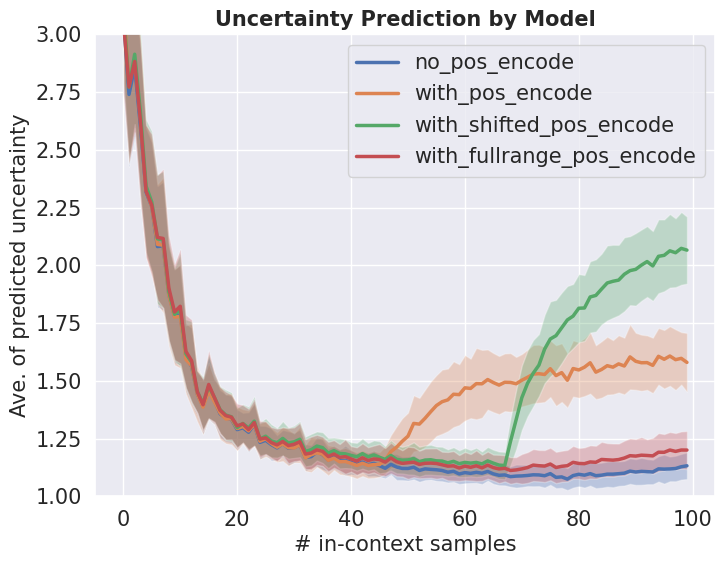

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

def softplus(arr):
    return np.log(1+np.exp(arr))

# all_experiments = ["leave045", "leave045_addEmbed", "leave045_addSegEmbed", "leave045_addFloatingEmbed"]
Sig_dic = {}
Sig_std_dic = {}
name_map = {
    "leave045": "no_pos_encode", 
    "leave045_addEmbed": "with_pos_encode", 
    "leave045_addSegEmbed": "with_shifted_pos_encode", 
    "leave045_addFloatingEmbed": "with_fullrange_pos_encode"
}


for experiment in all_experiments:


    Bayes_sigma = bayes_sigs_dic[experiment]
    

    Sig_dic[experiment] = softplus(predsigma_dic[experiment].numpy()).mean(axis=0)
    Sig_std_dic[experiment] = softplus(predsigma_dic[experiment].numpy()).std(axis=0)



# Sample data
x_range = 100
x_base = np.arange(0, x_range)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for experiment in all_experiments:
     ax.plot(x_base, savgol_filter(Sig_dic[experiment][:x_range], \
                                        window_length=1, polyorder=0), label=name_map[experiment], linewidth=2.5)
     
     ax.fill_between(x_base, Sig_dic[experiment][:x_range] - Sig_std_dic[experiment][:x_range]/2, \
                Sig_dic[experiment][:x_range] + Sig_std_dic[experiment][:x_range]/2, \
                     alpha=0.3)
     


# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('Ave. of predicted uncertainty', fontsize="15")
ax.set_ylim(1, 3) 
ax.set_title('Uncertainty Prediction by Model', fontsize="15", fontweight='bold')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15")

plt.savefig('figures/exp_3_std.eps', format='eps')
plt.savefig('figures/exp_3_std.png', format='png')

# Show plot
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


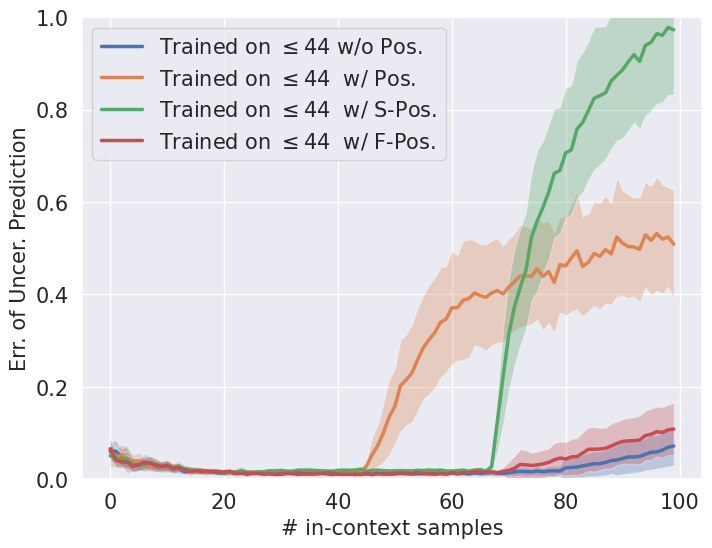

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

def softplus(arr):
    return np.log(1+np.exp(arr))

# all_experiments = ["leave045", "leave045_addEmbed", "leave045_addSegEmbed", "leave045_addFloatingEmbed"]
DevSig_dic = {}
DevSig_std_dic = {}
name_map = {
    "leave045": "Trained on $\leq 44$ w/o Pos.", 
    "leave045_addEmbed": "Trained on $\leq 44$  w/ Pos.", 
    "leave045_addSegEmbed": "Trained on $\leq 44$  w/ S-Pos.", 
    "leave045_addFloatingEmbed": "Trained on $\leq 44$  w/ F-Pos."
}


for experiment in all_experiments:


    Bayes_sigma = bayes_sigs_dic[experiment]
    

    DevSig_dic[experiment] = np.abs(Bayes_sigma - softplus(predsigma_dic[experiment].numpy())).mean(axis=0)
    DevSig_std_dic[experiment] = np.abs(Bayes_sigma - softplus(predsigma_dic[experiment].numpy())).std(axis=0)



# Sample data
x_range = 100
x_base = np.arange(0, x_range)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for experiment in all_experiments:
     ax.plot(x_base, savgol_filter(DevSig_dic[experiment][:x_range], \
                                        window_length=1, polyorder=0), label=name_map[experiment], linewidth=2.5)
     
     ax.fill_between(x_base, DevSig_dic[experiment][:x_range] - DevSig_std_dic[experiment][:x_range]/2, \
                DevSig_dic[experiment][:x_range] + DevSig_std_dic[experiment][:x_range]/2, \
                     alpha=0.3)
     


# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('Err. of Uncer. Prediction', fontsize="15")
ax.set_ylim(0, 1) 
# ax.set_title('Deviation from Bayes Optimal', fontsize="15", fontweight='bold')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15")

plt.savefig('figures/exp_3_Dev.eps', format='eps')
plt.savefig('figures/exp_3_Dev.png', format='png')

# Show plot
plt.show()
